<a href="https://colab.research.google.com/github/anath703/text_analytics_news/blob/main/analysis_anoop_nath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS5001 Final Project
* Anoop Nath (nux9aq)
* 12/09/2022

In this project, I will be doing text analytics on the Newzy data set, which is a collection of news feeds and stories from conservative and progressive sources from October 2013 to February 2020. 

In particular, I will be focusing on articles from two sources: Power Line and Politico. I will be using principal component analysis, word clouds, and sentiment analysis to get inisghts into these two sources and see if either or both have a polical bias. Knowing nothing about these two sources when I first started the project, it was fascinating for me to explore, compare, and contrast without any preconceived notions.

## Set Up

In [ ]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

In [ ]:
%%capture
! pip install pyLDAvis

In [ ]:
%%capture
! pip install texthero -q

In [ ]:
%%capture
! python -m spacy download en_core_web_sm

In [ ]:
%%capture
import pandas as pd
import numpy as np
from glob import glob
import re
from nltk.tokenize import sent_tokenize
from sklearn.decomposition import PCA
from scipy.linalg import norm
#import plotly_express as px
import seaborn as sns

In [ ]:
%%capture
import texthero as hero # text hero  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/newzy.csv', sep='|')

The dataset can be downloaded from here: https://virginia.app.box.com/s/bj8f1khrkfd6thm9umq35m6xp2an4zej/file/624341579635

In [ ]:
df.head()

,doc_id,doc_source,doc_title,doc_content,doc_date,doc_url
0,39,Google News,"50 Years on, Finding Profit in 'Truth' on JFK ...","Washington Post50 Years on, Finding Profit in ...",11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...
1,38,Google News,"Nearly 10 years later, families and officials ...","Washington PostNearly 10 years later, families...",11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...
2,37,Google News,"Cuccinelli, running hard, has been hobbled in ...","Washington PostCuccinelli, running hard, has b...",11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...
3,36,Google News,Chuck Schumer endorses Hillary Clinton for Pre...,New York Daily NewsChuck Schumer endorses Hill...,11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...
4,35,Google News,Sec. Kerry issues apparent warning to Iran - C...,Ahram OnlineSec. Kerry issues apparent warning...,11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...


In [ ]:
#convert doc_date to datetime
df['doc_date'] = pd.to_datetime(df['doc_date'])

In [ ]:
#Create a new column to indicate the year of the article
df['year']= df['doc_date'].dt.year

In [ ]:
df['doc_source'].value_counts()

US News                506364
UPI Latest              97830
Fox                     83417
Drudge Report           77063
Google News             64079
Real Clear Politics     40611
CNN                     38011
NPR                     30755
New York Times          21240
Reuters                 18506
Guardian                12392
Daily Kos               12310
Breitbart               10012
PowerLine                9730
Politico Magazine        3670
Name: doc_source, dtype: int64

## Data Cleaning

I want to only look at PowerLine and Politico Magazine since only these two sources have the complete story. I'm interested in analyzing full articles and the others only have one or two sentece blurbs.

In [ ]:
#filter for only Power Line and Politico
df= df[df['doc_source'].isin(['PowerLine', 'Politico Magazine'])]

In [ ]:
df.sample(5)

,doc_id,doc_source,doc_title,doc_content,doc_date,doc_url,year
510429,510465,Politico Magazine,The Tawdry and Dumb Nazi Charge,NaN,2018-06-28,https://www.politico.com/magazine/story/2018/0...,2018.0
258597,258633,PowerLine,Thoughts from the ammo line,(Scott Johnson) We all need this and Ammo Grrr...,2017-09-15,http://feeds.powerlineblog.com/~r/powerlineblo...,2017.0
655602,655638,PowerLine,"James Comey, cont’d",(Scott Johnson) Former FBI Director James Come...,2018-12-19,http://feeds.powerlineblog.com/~r/powerlineblo...,2018.0
425739,425775,PowerLine,"Anti-Semitic and dumb as a rock, Part Two",(Paul Mirengoff) Trayon White is the D.C. Coun...,2018-03-25,http://feeds.powerlineblog.com/~r/powerlineblo...,2018.0
260380,260416,Politico Magazine,The Juggalos Come to Washington,Insane Clown Posse supporters mobilize against...,2017-09-17,http://www.politico.com/magazine/gallery/2017/...,2017.0


It looks the author's name is showing up in the doc_content for Power Line articles. I'll remove these using regex.

In [ ]:
%%capture
df['doc_content']= df['doc_content'].str.replace(r"^\(.*?\)","")

There are also some wesbite urls in the text, so I'll remove these using regex as well.

In [ ]:
%%capture
df['doc_content']= df['doc_content'].str.replace(r'http\S+', '')

In [ ]:
df.sample(5)

,doc_id,doc_source,doc_title,doc_content,doc_date,doc_url,year
350881,350917,PowerLine,Sports: An Excuse to Talk About Politics,What was the biggest sports story of 2017? If...,2017-12-27,http://feeds.powerlineblog.com/~r/powerlineblo...,2017.0
511208,511244,PowerLine,Democratic establishment frets about the unhin...,There has been some hand wringing among estab...,2018-06-29,http://feeds.powerlineblog.com/~r/powerlineblo...,2018.0
276528,276564,Politico Magazine,"Mass Shootings Are Getting Deadlier, Not More ...",Data shows that mass public shootings are roug...,2017-10-04,http://www.politico.com/magazine/story/2017/10...,2017.0
2541,2577,Politico Magazine,The Psychological Quirk That Explains Why You ...,The popularity of the GOP front-runner can be ...,2016-05-26,http://www.politico.com/magazine/story/2016/05...,2016.0
472201,472237,PowerLine,"At the AP, the News Is What Didn’t Happen","Earlier today, President Trump met with a gro...",2018-05-15,http://feeds.powerlineblog.com/~r/powerlineblo...,2018.0


In [ ]:
#removing aricles that have NAs for doc_content
df= df.dropna(subset= ['doc_content'])

I'll be using a package called Text Hero to clean the text. According to their documentations, the package cleans a dataframe with text by doing the following:

- fillna(s) Replace not assigned values with empty spaces.
- lowercase(s) Lowercase all text.
- remove_digits() Remove all blocks of digits.
- remove_punctuation() Remove all string.punctuation (!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~).
- remove_diacritics() Remove all accents from strings.
- remove_stopwords() Remove all stop words.
- remove_whitespace() Remove all white space between words.

source: https://texthero.org/docs/getting-started#preprocessing

In [ ]:
df['clean_text'] = hero.clean(df['doc_content'])

In [ ]:
df.sample(5)

,doc_id,doc_source,doc_title,doc_content,doc_date,doc_url,year,clean_text
95078,95114,PowerLine,Judge Chuang’s case,Theodore Chuang is the United States District...,2017-03-17,http://feeds.powerlineblog.com/~r/powerlineblo...,2017.0,theodore chuang united states district judge m...
996088,996124,PowerLine,Fun and Games in the Senate,I haven’t spent a minute watching the absurd ...,2020-01-22,http://feeds.powerlineblog.com/~r/powerlineblo...,2020.0,' spent minute watching absurd impeachment pro...
211891,211927,PowerLine,How Trump inadvertently helps al Qaeda in Syria,I’ve discussed how President Trump’s collabor...,2017-07-26,http://feeds.powerlineblog.com/~r/powerlineblo...,2017.0,' discussed president trump' collaboration rus...
442793,442829,PowerLine,James Comey Confesses,It is a sign of the times that former FBI Dir...,2018-04-13,http://feeds.powerlineblog.com/~r/powerlineblo...,2018.0,sign times former fbi director james comey boo...
692837,692873,PowerLine,Loose Ends (65),• No sooner do I speculate yesterday that Ale...,2019-01-29,http://feeds.powerlineblog.com/~r/powerlineblo...,2019.0,* sooner speculate yesterday alexandria ocasio...


In [ ]:
df_powerline= df.query("doc_source =='PowerLine'")
df_politico= df.query("doc_source =='Politico Magazine'")


## Create LIBRARY table

In [ ]:
LIBRARY= df[['doc_id', 'doc_date', 'doc_source', 'doc_title']]

## Create TOKENS and VOCAB tables

In [ ]:
#function to tokenize
def tokenize(doc_df, OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.clean_text\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [ ]:
%%capture
df2= df[ ['doc_id', 'doc_source', 'clean_text', 'year'] ].set_index(['doc_id', 'doc_source', 'year'])
TOKENS = tokenize(df2, ['doc_id','doc_source', 'year', 'sent_num', 'token_id'], ws=True)

In [ ]:
%%capture
TOKENS['term_str'] = TOKENS['token_str'].str.lower().str.replace('[\W_]', '')

In [ ]:
VOCAB = TOKENS.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

In [ ]:
%%capture
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [ ]:
VOCAB

,term_str,n,num
term_id,,,
0,,102121,0
1,0,2,1
2,000km3,1,1
3,000lb,1,1
4,000th,2,1
...,...,...,...
63250,zycher,3,0
63251,zymeck,1,0
63252,zyuganov,1,0


### Add Stems

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
VOCAB['p_stem'] = VOCAB.term_str.apply(stemmer.stem)

In [ ]:
VOCAB = VOCAB[~VOCAB.term_str.isna()]

In [ ]:
VOCAB.sample(5)

,term_str,n,num,p_stem
term_id,,,,
33352,lucia,4,0,lucia
42733,pombo,1,0,pombo
49005,sane,90,0,sane
33751,maiden,3,0,maiden
45600,realsarahidan,3,0,realsarahidan


## Get TFIDF Matrix

In [ ]:
TOKENS = TOKENS[~TOKENS.term_str.isna()]
TOKENS['term_id'] = TOKENS.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)

In [ ]:
VOCAB['pos_max'] = TOKENS.groupby(['term_id', 'pos']).pos.count().unstack().idxmax(1) 

In [ ]:
BOW = TOKENS.groupby(['doc_id']+['term_id']).term_id.count()\
.to_frame().rename(columns={'term_id':'n'})    

In [ ]:
BOW['c'] = BOW.n.astype('bool').astype('int')

In [ ]:
#create a count matrix
count_method= 'n'
DTCM = BOW[count_method].unstack().fillna(0).astype('int')

In [ ]:
TF = DTCM.T / DTCM.T.sum()
TF = TF.T

In [ ]:
#Compute DF
DF = DTCM[DTCM > 0].count()

In [ ]:
#Compute IDF
N = DTCM.shape[0]
IDF = np.log10(N / DF)

In [ ]:
TFIDF = TF * IDF

In [ ]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,63245,63246,63247,63248,63249,63250,63251,63252,63253,63254
doc_id,,,,,,,,,,,,,,,,,,,,,
48,0.005755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.004006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.004115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0.002558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
VOCAB['tfidf_sum'] = TFIDF.sum()

In [ ]:
VOCAB.sort_values(by = 'tfidf_sum', ascending=False).head(20)

,term_str,n,num,p_stem,pos_max,tfidf_sum
term_id,,,,,,
57746,trump,24784,0,trump,NN,57.618385
0,,102121,0,,POS,47.933476
43482,president,12485,0,presid,NN,40.729757
14394,democrats,6228,0,democrat,NNS,27.138437
37896,new,7780,0,new,JJ,23.678279
26354,house,4475,0,hous,NN,22.822215
40869,party,3847,0,parti,NN,22.260618
2196,america,2826,0,america,NN,21.671051
39367,one,14137,0,one,CD,21.369126


The top 20 words with the highest TFIDF values are mostly related to politics. These include words like trump, campaign, clinton, etc. 

## Principal Component Analysis (PCA)

The Text Hero package can also do PCA relatively easily.

In [ ]:
df['pca'] = (
            df["clean_text"]
            .pipe(hero.tfidf)
            .pipe(hero.pca)
)

In [ ]:
df['tfidf'] = (
    df['clean_text']
    .pipe(hero.tfidf)
)

In [ ]:
## Scatterplot of PCA
hero.scatterplot(
    df,
    col= 'pca',
    color = 'doc_source',
    title= 'PCA of Newspaper Article Contents'
)
    

From the PCA chart, it looks like Politico has very little divergence in terms of the second componenet (y-axis). Meanwhile, Powerline has divergence in both the first and second componenets. My hypothesis is that since PowerLine is a far right new outlet, it tends to put out more  sensationalist stories than Politico, which is a more established, left-leaning, news outlet. 

Browsing the Power Line website, only adds confirmation to this theory as this was one of the "articles" on the front page.

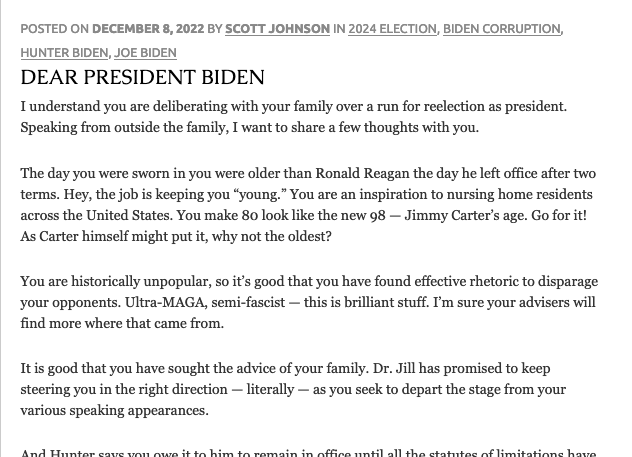



Source: https://www.powerlineblog.com/archives/2022/12/dear-president-biden.php

This reads more like a blog post someone created from their basement than a news article. There are other articles that are news related but this variety of content could explain why the PCA chart shows more varaition in both components for Power Line.


## Word Clouds

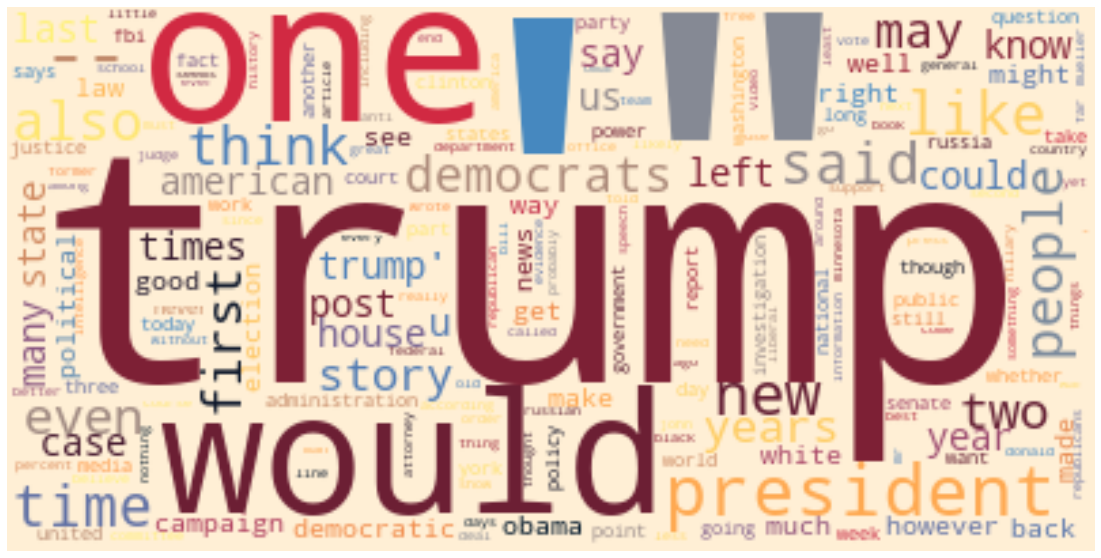

In [ ]:
hero.wordcloud(df_powerline['clean_text'])

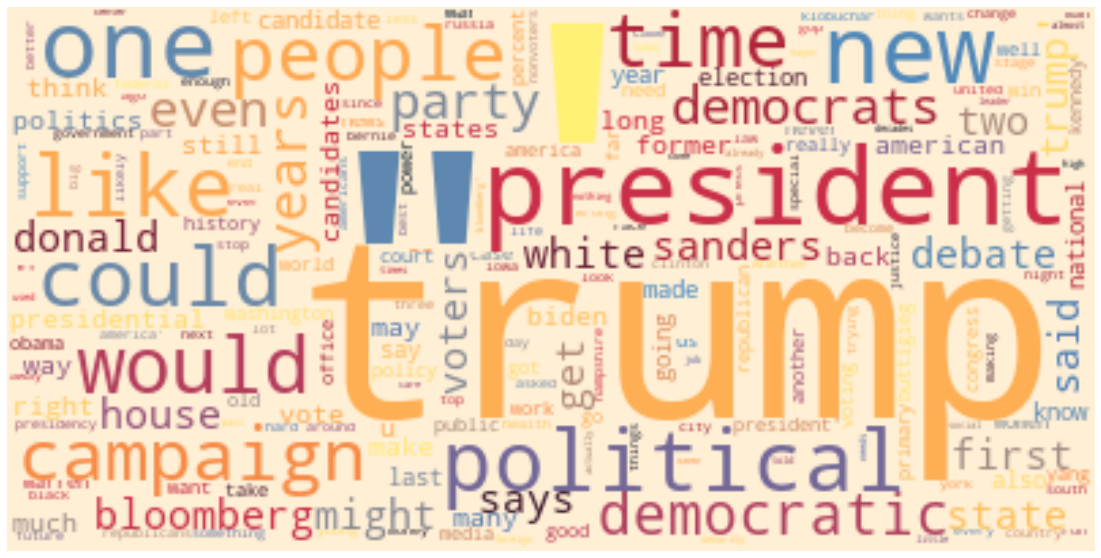

In [ ]:
hero.wordcloud(df_politico['clean_text'])

The word clouds for both look very similar with the largest words being related to politics such as Trump, Obama, president, campaign, etc. It's hard to tell if there's any political bias for the sources from these images.

## Topic Models (LDA)

Next, I'll create a topic model using Latent Dirichlet Allocation (LDA). The gensim package makes this very simple.

In [ ]:
import gensim
import gensim.corpora as corpora
from pprint import pprint

In [ ]:
words = df["clean_text"].map(lambda x: x.split(' '))  

In [ ]:
#to filter out special characters
removalList= ['"',"'", '..' , '-', '--', 'u', '*']

In [ ]:
#filtering out special characters
words2=pd.Series( )

cnt=0
for items in words.iteritems():
  newList= list(items[1])
  newList = [word for word in list(items[1]) if word not in removalList]
  words2.loc[cnt] = newList
  cnt= cnt+1

<ipython-input-53-a4fc8b76fb19>:2: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
words2= words2.set_axis(words.index)

In [ ]:
id2word = corpora.Dictionary(words2)

In [ ]:
corpus = [id2word.doc2bow(text) for text in words2]

In [ ]:
%%capture
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### Visualizations

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working



In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.144471  0.139919       1        1  17.310699
1      0.143829  0.326226       2        1  15.004286
6     -0.157638  0.037501       3        1  12.509533
2     -0.096384  0.340635       4        1  12.018410
3      0.027646 -0.396424       5        1  10.513663
8     -0.358468  0.163783       6        1   8.664647
9     -0.063798 -0.230953       7        1   7.732270
0     -0.360135 -0.192749       8        1   7.023037
5      0.310106 -0.212228       9        1   4.885237
4      0.410371  0.024290      10        1   4.338219, topic_info=           Term          Freq         Total Category  logprob  loglift
3611      trump  16873.000000  16873.000000  Default  30.0000  30.0000
196   president  10683.000000  10683.000000  Default  29.0000  29.0000
386   democrats   5653.000000   5653.000000  Default  28.0000  28.0000
4775       omar   3631.000000   3631.000000  Default  27.0000  27.0000
3591    sanders   5678.000000   5678.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
262        last    537.056794   4947.772133  Topic10  -5.3349   0.9171
271        past    426.819138   1998.623363  Topic10  -5.5647   1.5939
54         line    424.185505   2012.734036  Topic10  -5.5709   1.5806
792        case    392.269633   4423.785556  Topic10  -5.6491   0.7149
406       first    372.399252   5747.681962  Topic10  -5.7011   0.4011

[608 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
48803     10  0.996551            abdi
5427       6  0.997965        academic
6121       5  0.998964            adam
107        3  0.172715  administration
107        5  0.205178  administration
...      ...       ...             ...
2404       2  0.799823           young
2404       6  0.040267           young
2404       7  0.021318           young
2404       9  0.136594           young
2404      10  0.001579           young

[1183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 7, 3, 4, 9, 10, 1, 6, 5])

We can see some very clear topics. For example, topic eight has words such as Iran, Ukraine, Russia, and China so this topic seems to be related to foreign affairs.

Topic one hs words such as Trump, Biden, Sanders,president, Warren, and campaign so this seems to be realted to the presidential election. 

Meanwhile topic ten has words such as Omar, Ilhan, and Minnesota. This topic is clearly about Ilhan Omar, U.S. representative for Minnesota's 5th congressional district. I'm surprised to see that there is an entire topic for her because though polarizing, she is not at a high level of power within the U.S. government.

## Sentiment Analysis

I'll next focus on sentiment analysis. I'll be using the the NRC Emotion Lexicon, which associates each word with 8 different emotions.

In [ ]:
## Get Lexicon
salex=  pd.read_csv('/content/drive/MyDrive/salex_nrc.csv').set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]
salex['polarity'] = salex.positive - salex.negative

In [ ]:
salex

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


In [ ]:
##Get lexicon columns
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [ ]:
#join emotions to TOKENS dataframe
TOKENS = TOKENS.join(salex, on='term_str', how='left')
TOKENS[emo_cols] = TOKENS[emo_cols].fillna(0)

In [ ]:
TOKENS[['term_str'] + emo_cols].sample(10)

,,,,,term_str,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity
doc_id,doc_source,year,sent_num,token_id,,,,,,,,,,
966880,PowerLine,2019.0,0,230,draw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559785,PowerLine,2018.0,0,170,thought,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412547,PowerLine,2018.0,0,132,serve,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
577982,PowerLine,2018.0,0,24,schmidt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
482136,PowerLine,2018.0,0,70,cautionary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
515050,PowerLine,2018.0,0,191,multiple,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214164,PowerLine,2017.0,0,177,type,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74824,PowerLine,2017.0,0,158,enemy,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0
223554,PowerLine,2017.0,0,199,heavy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
TOKENS[emo_cols] = TOKENS[emo_cols].fillna(0)

In [ ]:
TOKENS.head()

pos_tuple  pos token_str  \
doc_id doc_source year   sent_num token_id                                  
48     PowerLine  2013.0 0        0                (', '')   ''         '   
                                  1         (falling, VBG)  VBG   falling   
                                  2           (behind, IN)   IN    behind   
                                  3             (many, JJ)   JJ      many   
                                  4          (regular, JJ)   JJ   regular   

                                           term_str  term_id  anger  \
doc_id doc_source year   sent_num token_id                            
48     PowerLine  2013.0 0        0                        0    0.0   
                                  1         falling    19879    0.0   
                                  2          behind     5188    0.0   
                                  3            many    34102    0.0   
                                  4         regular    46330    0.0   

                                            anticipation  disgust  fear  joy  \
doc_id doc_source year   sent_num token_id                                     
48     PowerLine  2013.0 0        0                  0.0      0.0   0.0  0.0   
                                  1                  0.0      0.0   0.0  0.0   
                                  2                  0.0      0.0   0.0  0.0   
                                  3                  0.0      0.0   0.0  0.0   
                                  4                  0.0      0.0   0.0  0.0   

                                            negative  positive  sadness  \
doc_id doc_source year   sent_num token_id                                
48     PowerLine  2013.0 0        0              NaN       NaN      0.0   
                                  1              1.0       0.0      1.0   
                                  2              NaN       NaN      0.0   
                                  3              NaN       NaN      0.0   
                                  4              NaN       NaN      0.0   

                                            surprise  trust  polarity  
doc_id doc_source year   sent_num token_id                             
48     PowerLine  2013.0 0        0              0.0    0.0       0.0  
                                  1              0.0    0.0      -1.0  
                                  2              0.0    0.0       0.0  
                                  3              0.0    0.0       0.0  
                                  4              0.0    0.0       0.0

In [ ]:
#create seperate TOKENS tables
TOKENS_powerline= TOKENS.query("doc_source =='PowerLine'")
TOKENS_politico= TOKENS.query("doc_source =='Politico Magazine'")

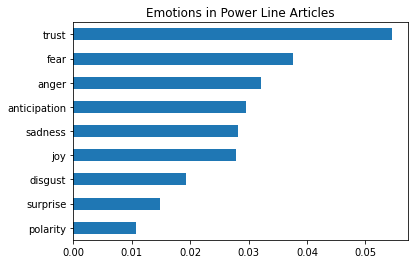

In [ ]:
#bar chart to show emotions for Power Line
TOKENS_powerline[emo_cols].mean().sort_values().plot.barh(title= 'Emotions in Power Line Articles')

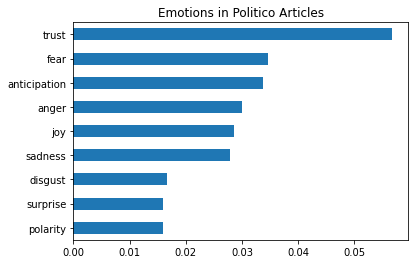

In [ ]:
#bar chart to show emotions for Politico
TOKENS_politico[emo_cols].mean().sort_values().plot.barh(title  = 'Emotions in Politico Articles')

The charts show that both Politico and Power Line have similar sentiment in their articles. The top four emotions in both are trust, fear, anger and anticipation. However, the polarity for Politico is slighly higher. Meanwhile,  negative emotions like anger, fear, and disgust are all higher for Power Line compared to Politico. This lines up with my experience of browsing the two sites as well.

### Polarity by Year

The texts for both sources span from late 2013 to early 2020. I'll explore if there has been changes in sentiment over the years for each news outlet.

In [ ]:
emotions_powerline_by_year = TOKENS_powerline.reset_index().groupby(['year'])[emo_cols].mean()
emotions_politico_by_year = TOKENS_politico.reset_index().groupby(['year'])[emo_cols].mean()

In [ ]:
def plot_sentiments(df, myTitle, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45, title= myTitle)
    df[emo].plot(**FIG)

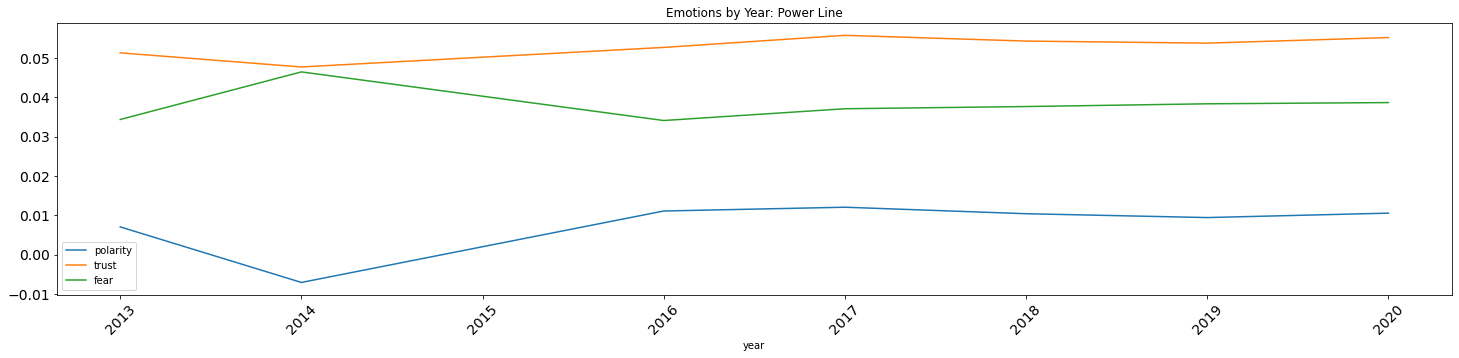

In [ ]:
plot_sentiments(emotions_powerline_by_year, 'Emotions by Year: Power Line', ['polarity', 'trust', 'fear'])

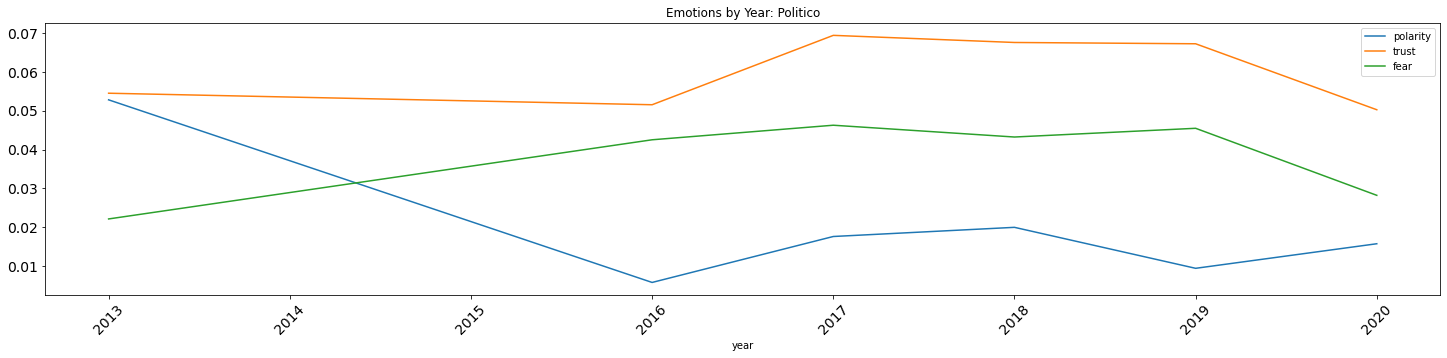

In [ ]:
plot_sentiments(emotions_politico_by_year, 'Emotions by Year: Politico', ['polarity', 'trust', 'fear'])

There is a very clear trend in the two charts above. For Power Line We can see that polarity was very low from 2013 to 2015, then increases from 2016 onwards. Meanwhile, there is a dip in fear and an increase in trust starting in 2016. 

We see the opposite trend for Politico, with polarity dropping and fear increasing from 2016 onwards. Although you do see an increase in trust in 2017.  

It's no coincidence that we see such suddent shifts in sentiment in 2016, which was the year Donald Trump won the presidential election. From these charts, it seems like Power Line is a right-leaning source while Politico is left-leaning.

## Sources

- “Getting Started · Texthero.” Texthero Blog ATOM, https://texthero.org/docs/getting-started#preprocessing. 
- Johnson, S. (2022, December 8). Dear President Biden. Power Line. 

## Saving to CSV

In [ ]:
TOKENS.to_csv('TOKENS.csv', index=False)

In [ ]:
VOCAB.to_csv('VOCAB.csv', index=False)

In [ ]:
LIBRARY.to_csv('LIBRARY.csv', index=False)